## libraries

In [1]:
import pandas as pd
import numpy as np
import math
import random
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import linalg

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score

# sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

# Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Forest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import IsolationForest

# Boosting
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Bagging
from sklearn.ensemble import BaggingClassifier

# DBSCAN
from sklearn.cluster import DBSCAN

## Data

In [2]:
df = pd.read_csv('../creditcard.csv')

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df = df.sample(frac=1)  #shuffle


# undersampling
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
df_un = normal_distributed_df.sample(frac=1, random_state=42)

# oversampling with SMOTE
sm = SMOTE(sampling_strategy='minority')
X_sm, y_sm = sm.fit_resample(df.drop('Class', axis=1), df['Class'])

In [3]:
X_sm.shape, y_sm.shape

((568630, 30), (568630,))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), df['Class'], test_size=0.3, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((199364, 30), (199364,), (85443, 30), (85443,))

In [5]:
X_train_un, X_test_un, y_train_un, y_test_un = train_test_split(df_un.drop('Class', axis=1), df_un['Class'], test_size=0.3, random_state=42)
X_train_un.shape, y_train_un.shape, X_test_un.shape, y_test_un.shape

((688, 30), (688,), (296, 30), (296,))

In [6]:
X_train_ov, X_test_ov, y_train_ov, y_test_ov = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)
X_train_ov.shape, y_train_ov.shape, X_test_ov.shape, y_test_ov.shape

((398041, 30), (398041,), (170589, 30), (170589,))

# all model

In [20]:
random.seed(42)

all_model = {
    # classifier
    "LogisticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "Naive Bayes": GaussianNB(),
    
    # tree
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "randomforest" : RandomForestClassifier(),
    "extratree" : ExtraTreesClassifier(),
    
    # boosting
    "adaboost" : AdaBoostClassifier(),
    "gradientboost" : GradientBoostingClassifier(),
    "xgboost" : XGBClassifier(),
    "lgbm" : LGBMClassifier(),
    "catboost" : CatBoostClassifier(),
    "bagging" : BaggingClassifier(),
}

res = pd.DataFrame(index=all_model.keys(), columns=['accuracy', 'f1score_weighted', 'rocauc'])

for key, model in all_model.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    res['accuracy'][key] = round(accuracy_score(y_test, y_pred), 6)
    res['f1score_weighted'][key] = round(f1_score(y_test, y_pred, average='weighted'), 6)
    res['rocauc'][key] = round(roc_auc_score(y_test, y_pred), 6)
    print(key, 'done')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression done
KNearest done
Support Vector Classifier done
Naive Bayes done
DecisionTreeClassifier done
randomforest done
extratree done
adaboost done
gradientboost done


/home/jovyan/.venv/horovod0.20.3-tf2.3.0-torch1.6.0-mxnet1.6.0-py3.7-cuda10.1/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:14:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgboost done
lgbm done
Learning rate set to 0.098829
0:	learn: 0.3739429	total: 63.7ms	remaining: 1m 3s
1:	learn: 0.1974038	total: 76.5ms	remaining: 38.2s
2:	learn: 0.1149849	total: 89.4ms	remaining: 29.7s
3:	learn: 0.0640361	total: 102ms	remaining: 25.4s
4:	learn: 0.0373903	total: 114ms	remaining: 22.7s
5:	learn: 0.0231741	total: 126ms	remaining: 20.9s
6:	learn: 0.0154965	total: 138ms	remaining: 19.6s
7:	learn: 0.0106335	total: 150ms	remaining: 18.6s
8:	learn: 0.0079443	total: 161ms	remaining: 17.8s
9:	learn: 0.0062801	total: 174ms	remaining: 17.2s
10:	learn: 0.0052391	total: 186ms	remaining: 16.7s
11:	learn: 0.0044959	total: 198ms	remaining: 16.3s
12:	learn: 0.0039526	total: 211ms	remaining: 16s
13:	learn: 0.0035558	total: 223ms	remaini

In [21]:
res.to_csv('result.csv')

In [22]:
random.seed(42)

all_model = {
    # classifier
    "LogisticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "Naive Bayes": GaussianNB(),
    
    # tree
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "randomforest" : RandomForestClassifier(),
    "extratree" : ExtraTreesClassifier(),
    
    # boosting
    "adaboost" : AdaBoostClassifier(),
    "gradientboost" : GradientBoostingClassifier(),
    "xgboost" : XGBClassifier(),
    "lgbm" : LGBMClassifier(),
    "catboost" : CatBoostClassifier(),
    "bagging" : BaggingClassifier(),
}

undersampling_res = pd.DataFrame(index=all_model.keys(), columns=['accuracy', 'f1score_weighted', 'rocauc'])

for key, model in all_model.items():
    model.fit(X_train_un, y_train_un)
    y_pred_un = model.predict(X_test_un)
    undersampling_res['accuracy'][key] = round(accuracy_score(y_test_un, y_pred_un), 6)
    undersampling_res['f1score_weighted'][key] = round(f1_score(y_test_un, y_pred_un, average='weighted'), 6)
    undersampling_res['rocauc'][key] = round(roc_auc_score(y_test_un, y_pred_un), 6)

/home/jovyan/.venv/horovod0.20.3-tf2.3.0-torch1.6.0-mxnet1.6.0-py3.7-cuda10.1/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:29:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.008782
0:	learn: 0.6777338	total: 7.34ms	remaining: 7.34s
1:	learn: 0.6669425	total: 68.1ms	remaining: 34s
2:	learn: 0.6559705	total: 70.1ms	remaining: 23.3s
3:	learn: 0.6437787	total: 72.1ms	remaining: 18s
4:	learn: 0.6333828	total: 74.1ms	remaining: 14.8s
5:	learn: 0.6238501	total: 76.3ms	remaining: 12.6s
6:	learn: 0.6101615	total: 78.3ms	remaining: 11.1s
7:	learn: 0.5983605	total: 80.1ms	remaining: 9.94s
8:	learn: 0.5872349	total: 82ms	remaining: 9.03s
9:	learn: 0.5758816	total: 83.9ms	remaining: 8.31s
10:	learn: 0.5661734	total: 85.9ms	remaining: 7.72s
11:	learn: 0.5559859	total: 87.8ms	remaining: 7.23s
12:	learn: 0.5463517	total: 89.7ms	remaining: 6.81s
13:	learn: 0.5370555	total: 91.6ms	remaining: 6.45s
14:	le

In [24]:
undersampling_res.to_csv('undersampling_res.csv')

In [7]:
random.seed(42)

all_model = {
    # classifier
    "LogisticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "Naive Bayes": GaussianNB(),
    
    # tree
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "randomforest" : RandomForestClassifier(),
    "extratree" : ExtraTreesClassifier(),
    
    # boosting
    "adaboost" : AdaBoostClassifier(),
    "gradientboost" : GradientBoostingClassifier(),
    "xgboost" : XGBClassifier(),
    "lgbm" : LGBMClassifier(),
    "catboost" : CatBoostClassifier(),
    "bagging" : BaggingClassifier(),
}

oversampling_res = pd.DataFrame(index=all_model.keys(), columns=['accuracy','f1score_weighted', 'rocauc'])

for key, model in all_model.items():
    model.fit(X_train_ov, y_train_ov)
    y_pred_ov = model.predict(X_test_ov)
    oversampling_res['accuracy'][key] = round(accuracy_score(y_test_ov, y_pred_ov), 6)
    oversampling_res['f1score_weighted'][key] = round(f1_score(y_test_ov, y_pred_ov, average='weighted'), 6)
    oversampling_res['rocauc'][key] = round(roc_auc_score(y_test_ov, y_pred_ov), 6)

/home/jovyan/.venv/horovod0.20.3-tf2.3.0-torch1.6.0-mxnet1.6.0-py3.7-cuda10.1/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:15:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.132771
0:	learn: 0.4456599	total: 76.6ms	remaining: 1m 16s
1:	learn: 0.3328788	total: 99.8ms	remaining: 49.8s
2:	learn: 0.2465952	total: 123ms	remaining: 41s
3:	learn: 0.2034839	total: 147ms	remaining: 36.6s
4:	learn: 0.1768339	total: 170ms	remaining: 33.8s
5:	learn: 0.1573553	total: 192ms	remaining: 31.8s
6:	learn: 0.1432422	total: 215ms	remaining: 30.5s
7:	learn: 0.1317770	total: 239ms	remaining: 29.6s
8:	learn: 0.1242585	total: 260ms	remaining: 28.6s
9:	learn: 0.1168829	total: 280ms	remaining: 27.7s
10:	learn: 0.1096400	total: 301ms	remaining: 27s
11:	learn: 0.1031425	total: 320ms	remaining: 26.3s
12:	learn: 0.0984005	total: 339ms	remaining: 25.8s
13:	learn: 0.0942093	total: 359ms	remaining: 25.3s
14:	learn: 0.09

In [8]:
oversampling_res.to_csv('oversampling_res.csv')

# Classifier

In [19]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(classifier.__class__.__name__, "training score:", training_score.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression training score: 0.9991773839303351
KNeighborsClassifier training score: 0.9993980861647449
SVC training score: 0.9993479267833075
DecisionTreeClassifier training score: 0.9990519845332365


In [20]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

for key, classifier in classifiers.items():
    classifier.fit(X_train_un, y_train_un)
    training_score = cross_val_score(classifier, X_train_un, y_train_un, cv=5)
    print(classifier.__class__.__name__, "undersampling training score:", training_score.mean())

LogisticRegression undersampling training score: 0.9360837829260552
KNeighborsClassifier undersampling training score: 0.9331746535491379
SVC undersampling training score: 0.9360732042737755
DecisionTreeClassifier undersampling training score: 0.9113508938961177


In [32]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

for key, classifier in classifiers.items():
    classifier.fit(X_train_ov, y_train_ov)
    training_score = cross_val_score(classifier, X_train_ov, y_train_ov, cv=5)
    print(classifier.__class__.__name__, "oversampling training score:", training_score.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression oversampling training score: 0.9486861891655854
KNeighborsClassifier oversampling training score: 0.9984574457550737
SVC oversampling training score: 0.9743091790719646
DecisionTreeClassifier oversampling training score: 0.9973419818977856


# Boosting
여러개의 학습모형을 연결하여 앞의 모형을 보완해 가면서 뒤로 갈수록 더욱 강한 모형을 만듬

In [27]:
all_model = {
    "adaboost" : AdaBoostClassifier(),
    "gradientboost" : GradientBoostingClassifier(),
    "xgboost" : XGBClassifier(),
    "lgbm" : LGBMClassifier(),
    "catboost" : CatBoostClassifier(),
    "bagging" : BaggingClassifier(),
    "randomforest" : RandomForestClassifier(),
    "isolationforest" : IsolationForest(),
    "extratree" : ExtraTreesClassifier(),
}

for key, model in all_model.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model.__class__.__name__, "accuracy score:", accuracy_score(y_test, y_pred))

AdaBoostClassifier accuracy score: 0.9990988144142879
GradientBoostingClassifier accuracy score: 0.9984785178423042


/home/jovyan/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:06:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier accuracy score: 0.9996371850239341
LGBMClassifier accuracy score: 0.9970389616469459
Learning rate set to 0.098829
0:	learn: 0.3783056	total: 21.4ms	remaining: 21.3s
1:	learn: 0.2036131	total: 40.2ms	remaining: 20.1s
2:	learn: 0.1190872	total: 59.8ms	remaining: 19.9s
3:	learn: 0.0683784	total: 78.1ms	remaining: 19.5s
4:	learn: 0.0406517	total: 95.8ms	remaining: 19.1s
5:	learn: 0.0261772	total: 115ms	remaining: 19.1s
6:	learn: 0.0179714	total: 135ms	remaining: 19.2s
7:	learn: 0.0124391	total: 153ms	remaining: 18.9s
8:	learn: 0.0091574	total: 170ms	remaining: 18.7s
9:	learn: 0.0072396	total: 188ms	remaining: 18.6s
10:	learn: 0.0060337	total: 205ms	remaining: 18.4s
11:	learn: 0.0052480	total: 223ms	remaining: 18.3s
12:	learn: 0

In [29]:
all_model = {
    "adaboost" : AdaBoostClassifier(),
    "gradientboost" : GradientBoostingClassifier(),
    "xgboost" : XGBClassifier(),
    "lgbm" : LGBMClassifier(),
    "catboost" : CatBoostClassifier(),
    "bagging" : BaggingClassifier(),
    "randomforest" : RandomForestClassifier(),
    "isolationforest" : IsolationForest(),
    "extratree" : ExtraTreesClassifier(),
}

for key, model in all_model.items():
    model.fit(X_train_un, y_train_un)
    y_pred_un = model.predict(X_test_un)
    print(model.__class__.__name__, "undersampling accuracy score:", accuracy_score(y_test_un, y_pred_un))

AdaBoostClassifier undersampling accuracy score: 0.9222972972972973
GradientBoostingClassifier undersampling accuracy score: 0.918918918918919


/home/jovyan/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:17:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier undersampling accuracy score: 0.9290540540540541
LGBMClassifier undersampling accuracy score: 0.9391891891891891
Learning rate set to 0.008782
0:	learn: 0.6800411	total: 2.2ms	remaining: 2.2s
1:	learn: 0.6690439	total: 4.35ms	remaining: 2.17s
2:	learn: 0.6583557	total: 6.59ms	remaining: 2.19s
3:	learn: 0.6458040	total: 8.92ms	remaining: 2.22s
4:	learn: 0.6359168	total: 11.4ms	remaining: 2.27s
5:	learn: 0.6239139	total: 13.8ms	remaining: 2.28s
6:	learn: 0.6146021	total: 16.4ms	remaining: 2.33s
7:	learn: 0.6051881	total: 74ms	remaining: 9.18s
8:	learn: 0.5946728	total: 76.8ms	remaining: 8.46s
9:	learn: 0.5846861	total: 79.5ms	remaining: 7.87s
10:	learn: 0.5744101	total: 82.2ms	remaining: 7.39s
11:	learn: 0.5636908	total: 84.8m

In [31]:
all_model = {
    "adaboost" : AdaBoostClassifier(),
    "gradientboost" : GradientBoostingClassifier(),
    "xgboost" : XGBClassifier(),
    "lgbm" : LGBMClassifier(),
    "catboost" : CatBoostClassifier(),
    "bagging" : BaggingClassifier(),
    "randomforest" : RandomForestClassifier(),
    "isolationforest" : IsolationForest(),
    "extratree" : ExtraTreesClassifier(),
}

for key, model in all_model.items():
    model.fit(X_train_ov, y_train_ov)
    y_pred_ov = model.predict(X_test_ov)
    print(model.__class__.__name__, "oversampling accuracy score:", accuracy_score(y_test_ov, y_pred_ov))

AdaBoostClassifier oversampling accuracy score: 0.963432577716031
GradientBoostingClassifier oversampling accuracy score: 0.9773021707144072


/home/jovyan/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:33:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier oversampling accuracy score: 0.9997127599083176
LGBMClassifier oversampling accuracy score: 0.9991617278957026
Learning rate set to 0.132771
0:	learn: 0.4451222	total: 39.4ms	remaining: 39.4s
1:	learn: 0.3178347	total: 75ms	remaining: 37.4s
2:	learn: 0.2504344	total: 110ms	remaining: 36.4s
3:	learn: 0.2097651	total: 158ms	remaining: 39.2s
4:	learn: 0.1783689	total: 207ms	remaining: 41.2s
5:	learn: 0.1563298	total: 253ms	remaining: 41.8s
6:	learn: 0.1447263	total: 285ms	remaining: 40.5s
7:	learn: 0.1321922	total: 319ms	remaining: 39.6s
8:	learn: 0.1240147	total: 351ms	remaining: 38.6s
9:	learn: 0.1150110	total: 387ms	remaining: 38.3s
10:	learn: 0.1085812	total: 419ms	remaining: 37.7s
11:	learn: 0.1016020	total: 452ms	remainin

## AdaBoost
- 이전 모형을 보완하여 새로운 모형을 만드는 방법의 기본은 이전 모형이 잘 맞추지 못한 데이터에 대해 가중치를 더 높임
- 새로운 모형은 가중치가 더 높은 데이터를 잘 구분하려고 하므로 어려운 데이터를 점점 더 잘 분류할 수 있게 됨
- 단점: Bagging이나 Pating처럼 병렬화가 안됨

In [26]:
ada_clf = AdaBoostClassifier( 
    DecisionTreeClassifier(max_depth=1), 
    n_estimators=200, 
    algorithm="SAMME.R", 
    learning_rate=0.5 
)
ada_clf.fit(X_train, y_train) 

y_pred = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9993562960102056

## Gradient Boost
이전 모형이 만든 잔여 오차에 대한 새로운 모형을 학습시킴

In [ ]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)

y_pred = gb_clf.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_pred))

## 확률적 그래디언트 부스트 (Stochastic Gradient Boost)
- 그래디언트 부스트 방안이 트리를 학습할때 사용할 학습 데이터의 비율 지정
- 데이터를 무작위로 뽑아서 학습

## XGBOOST

In [ ]:
xgb_clf = xgboost.XGBClassifier(max_depth=2, eta=1)
xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_pred))

## lightGBM

In [ ]:
lgb_clf = lightgbm.LGBMClassifier()
lgb_clf.fit(X_train, y_train)

y_pred = lgb_clf.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_pred))

## CATBOOST

In [ ]:
cat_clf = catboost.CatBoostClassifier()
cat_clf.fit(X_train, y_train)

y_pred = cat_clf.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_pred))

## Bagging

In [53]:
bag_clf = BaggingClassifier(
    LogisticRegression(max_iter=100000), 
    n_estimators = 500, 
    max_samples = 100, 
    bootstrap = True, 
    n_jobs = -1
)

bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9982444436641972

In [ ]:
bag_clf = BaggingClassifier()
bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_pred))

## Random Forest

In [56]:
rnd_clf = RandomForestClassifier(
    n_estimators = 500,  
    max_features = 'auto', 
    max_samples=0.5,    
    bootstrap = True,
    n_jobs=-1
)

rnd_clf.fit(X_train, y_train)

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9994850368081645

In [ ]:
rnd_clf = RandomForestClassifier()
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_pred))

## Isolation Forest

In [188]:
iforest = IsolationForest()

iforest.fit(X_train, y_train)

y_pred = iforest.predict(X_test)
y_pred = [1 if x==-1 else 0 for x in y_pred]
print('accuracy:', accuracy_score(y_test, y_pred))
print('f1score micro:', f1_score(y_test, y_pred, average='micro'))
print('f1score weighted:', f1_score(y_test, y_pred, average='weighted'))
print('rocauc:', roc_auc_score(y_test, y_pred))

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


accuracy: 0.9634142059618693
f1score micro: 0.9634142059618693
f1score weighted: 0.979837775464365
rocauc: 0.9073318726906205


In [189]:
iforest = IsolationForest()

iforest.fit(X_train_un, y_train_un)

y_pred_un = iforest.predict(X_test_un)
y_pred_un = [1 if x==-1 else 0 for x in y_pred_un]
print('accuracy:', accuracy_score(y_test_un, y_pred_un))
print('f1score micro:', f1_score(y_test_un, y_pred_un, average='micro'))
print('f1score weighted:', f1_score(y_test_un, y_pred_un, average='weighted'))
print('rocauc:', roc_auc_score(y_test_un, y_pred_un))

accuracy: 0.5878378378378378
f1score micro: 0.5878378378378378
f1score weighted: 0.5351616640679142
rocauc: 0.6215220195319698


/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


In [190]:
iforest = IsolationForest()

iforest.fit(X_train_ov, y_train_ov)

y_pred_ov = iforest.predict(X_test_ov)
y_pred_ov = [1 if x==-1 else 0 for x in y_pred_ov]
print('accuracy:', accuracy_score(y_test_ov, y_pred_ov))
print('f1score micro:', f1_score(y_test_ov, y_pred_ov, average='micro'))
print('f1score weighted:', f1_score(y_test_ov, y_pred_ov, average='weighted'))
print('rocauc:', roc_auc_score(y_test_ov, y_pred_ov))

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


accuracy: 0.6170737855313062
f1score micro: 0.6170737855313062
f1score weighted: 0.5561024844051685
rocauc: 0.6177936044045674


## Extra tree

In [66]:
et_clf = ExtraTreesClassifier(
    n_estimators = 500, 
    max_leaf_nodes = 16, 
    max_features = 'auto', 
    n_jobs=-1
)

et_clf.fit(X_train, y_train)

y_pred = et_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9988530365272755

In [ ]:
et_clf = ExtraTreesClassifier()
et_clf.fit(X_train, y_train)

y_pred = et_clf.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_pred))

# Deep Learning

In [192]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

In [193]:
n_inputs = X_train.shape[1]

model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)
pred = model.predict_classes(X_test, batch_size=200, verbose=0)

print('accuracy:', accuracy_score(y_test, y_pred))
print('f1score micro:', f1_score(y_test, y_pred, average='micro'))
print('f1score weighted:', f1_score(y_test, y_pred, average='weighted'))
print('rocauc:', roc_auc_score(y_test, y_pred))

Epoch 1/20
6380/6380 - 15s - loss: 0.0068 - accuracy: 0.9991 - val_loss: 0.0040 - val_accuracy: 0.9993
Epoch 2/20
6380/6380 - 15s - loss: 0.0033 - accuracy: 0.9994 - val_loss: 0.0037 - val_accuracy: 0.9993
Epoch 3/20
6380/6380 - 14s - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0031 - val_accuracy: 0.9994
Epoch 4/20
6380/6380 - 14s - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0035 - val_accuracy: 0.9993
Epoch 5/20
6380/6380 - 14s - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0033 - val_accuracy: 0.9993
Epoch 6/20
6380/6380 - 14s - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.0029 - val_accuracy: 0.9994
Epoch 7/20
6380/6380 - 14s - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.0032 - val_accuracy: 0.9995
Epoch 8/20
6380/6380 - 14s - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.0030 - val_accuracy: 0.9994
Epoch 9/20
6380/6380 - 14s - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.0030 - val_accuracy: 0.9993
Epoch 10/20
6380/6380 - 14s - loss: 0.0019 - accuracy: 0.9996 - val_loss:

In [194]:
n_inputs = X_train_un.shape[1]

under_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

under_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
under_model.fit(X_train_un, y_train_un, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)
y_pred_un = under_model.predict_classes(X_test_un, batch_size=200, verbose=0)

print('accuracy:', accuracy_score(y_test_un, y_pred_un))
print('f1score micro:', f1_score(y_test_un, y_pred_un, average='micro'))
print('f1score weighted:', f1_score(y_test_un, y_pred_un, average='weighted'))
print('rocauc:', roc_auc_score(y_test_un, y_pred_un))

Epoch 1/20
22/22 - 0s - loss: 0.7301 - accuracy: 0.5073 - val_loss: 0.5303 - val_accuracy: 0.6087
Epoch 2/20
22/22 - 0s - loss: 0.4635 - accuracy: 0.7327 - val_loss: 0.3908 - val_accuracy: 0.8188
Epoch 3/20
22/22 - 0s - loss: 0.3468 - accuracy: 0.8836 - val_loss: 0.3194 - val_accuracy: 0.8986
Epoch 4/20
22/22 - 0s - loss: 0.2798 - accuracy: 0.9291 - val_loss: 0.2692 - val_accuracy: 0.9275
Epoch 5/20
22/22 - 0s - loss: 0.2342 - accuracy: 0.9345 - val_loss: 0.2369 - val_accuracy: 0.9275
Epoch 6/20
22/22 - 0s - loss: 0.1993 - accuracy: 0.9473 - val_loss: 0.2166 - val_accuracy: 0.9348
Epoch 7/20
22/22 - 0s - loss: 0.1767 - accuracy: 0.9509 - val_loss: 0.2050 - val_accuracy: 0.9348
Epoch 8/20
22/22 - 0s - loss: 0.1599 - accuracy: 0.9527 - val_loss: 0.2044 - val_accuracy: 0.9275
Epoch 9/20
22/22 - 0s - loss: 0.1472 - accuracy: 0.9545 - val_loss: 0.1979 - val_accuracy: 0.9275
Epoch 10/20
22/22 - 0s - loss: 0.1380 - accuracy: 0.9545 - val_loss: 0.1973 - val_accuracy: 0.9275
Epoch 11/20
22/22 -

In [195]:
n_inputs = X_train_ov.shape[1]

over_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

over_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
over_model.fit(X_train_ov, y_train_ov, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)
y_pred_ov = over_model.predict_classes(X_test_ov, batch_size=200, verbose=0)

print('accuracy:', accuracy_score(y_test_ov, y_pred_ov))
print('f1score micro:', f1_score(y_test_ov, y_pred_ov, average='micro'))
print('f1score weighted:', f1_score(y_test_ov, y_pred_ov, average='weighted'))
print('rocauc:', roc_auc_score(y_test_ov, y_pred_ov))

Epoch 1/20
1062/1062 - 3s - loss: 0.1022 - accuracy: 0.9601 - val_loss: 0.0407 - val_accuracy: 0.9850
Epoch 2/20
1062/1062 - 3s - loss: 0.0259 - accuracy: 0.9923 - val_loss: 0.0166 - val_accuracy: 0.9961
Epoch 3/20
1062/1062 - 3s - loss: 0.0124 - accuracy: 0.9971 - val_loss: 0.0098 - val_accuracy: 0.9978
Epoch 4/20
1062/1062 - 3s - loss: 0.0079 - accuracy: 0.9982 - val_loss: 0.0069 - val_accuracy: 0.9983
Epoch 5/20
1062/1062 - 3s - loss: 0.0060 - accuracy: 0.9987 - val_loss: 0.0065 - val_accuracy: 0.9981
Epoch 6/20
1062/1062 - 2s - loss: 0.0048 - accuracy: 0.9990 - val_loss: 0.0054 - val_accuracy: 0.9986
Epoch 7/20
1062/1062 - 2s - loss: 0.0042 - accuracy: 0.9991 - val_loss: 0.0034 - val_accuracy: 0.9992
Epoch 8/20
1062/1062 - 3s - loss: 0.0036 - accuracy: 0.9993 - val_loss: 0.0034 - val_accuracy: 0.9992
Epoch 9/20
1062/1062 - 2s - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0033 - val_accuracy: 0.9991
Epoch 10/20
1062/1062 - 3s - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0029 - 

# Mixture Model

In [31]:
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

In [42]:
gm = GaussianMixture(n_components=2, random_state=42).fit(X_train)
pred = gm.predict(X_test)
accuracy_score(y_test, pred)

0.6287466498133258

In [43]:
gm_un = GaussianMixture(n_components=2, random_state=42).fit(X_train_un)
pred_un = gm_un.predict(X_test_un)
accuracy_score(y_test_un, pred_un)

0.6587837837837838

In [44]:
gm_ov = GaussianMixture(n_components=2, random_state=42).fit(X_train_ov)
pred_ov = gm_ov.predict(X_test_ov)
accuracy_score(y_test_ov, pred_ov)

0.3377357273915669

In [38]:
bgm = BayesianGaussianMixture(n_components=2, random_state=42).fit(X_train)
pred = bgm.predict(X_test)
accuracy_score(y_test, pred)

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


0.6248142036211275

In [40]:
bgm_un = BayesianGaussianMixture(n_components=2, random_state=42).fit(X_train_un)
pred_un = bgm_un.predict(X_test_un)
accuracy_score(y_test_un, pred_un)

0.6452702702702703

In [41]:
bgm_ov = BayesianGaussianMixture(n_components=2, random_state=42).fit(X_train_ov)
pred_ov = bgm_ov.predict(X_test_ov)
accuracy_score(y_test_ov, pred_ov)

0.33706745452520387

## scatter Gaussian Mixture

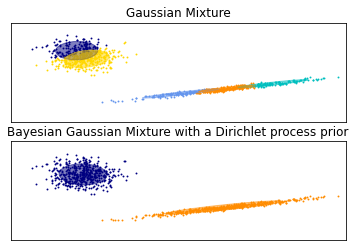

In [88]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)


# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = mixture.BayesianGaussianMixture(n_components=5,
                                        covariance_type='full').fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior')

plt.show()